<a href="https://colab.research.google.com/github/Prasadchaskar/Potato-Disease/blob/main/Potato_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [91]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=8

In [92]:
# import zipfile
# !unzip /content/drive/MyDrive/PlantVillage.zip

In [93]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [94]:
class_names = dataset.class_names

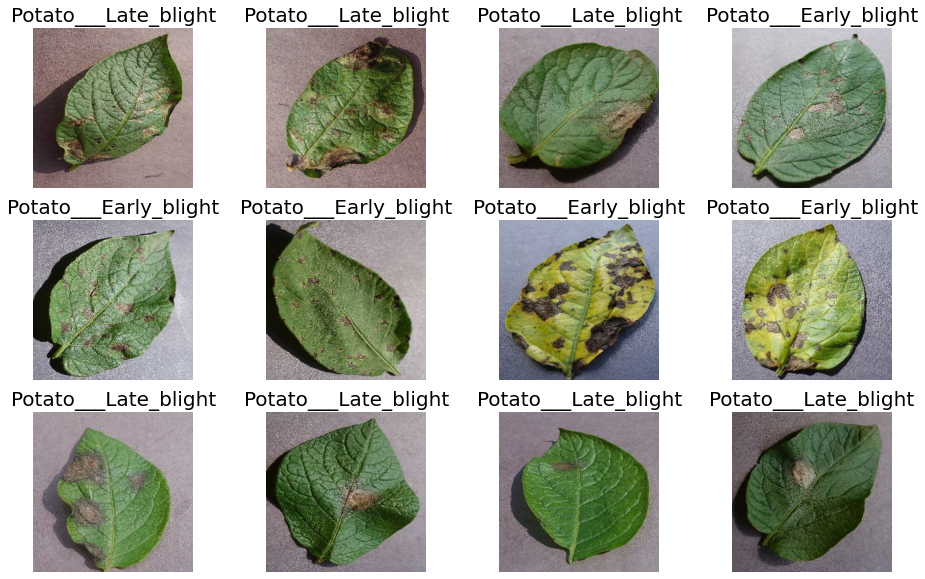

In [95]:
plt.figure(figsize=(16,10))
for img,lbl in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[lbl[i]],{'fontsize':20})
        plt.axis("off")

In [96]:
    # train_data = dataset.take(54)
    # test_data  = dataset.skip(54)
    # val_data   = test_data.take(6)
    # test_data = test_data.skip(6)

In [97]:
# print(f"Training Data:{len(train_data)} , Test Data:{len(test_data)}, Validation Data:{len(val_data)}")

In [98]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [99]:
train_data,val_data,test_data = get_dataset_partitions_tf(dataset)

In [100]:
print(f"Training Data:{len(train_data)} , Test Data:{len(test_data)}, Validation Data:{len(val_data)}")

Training Data:54 , Test Data:8, Validation Data:6


In [101]:
train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [102]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [103]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [104]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [105]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [106]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [107]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [108]:
history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1, 
        epochs=8,
    )

Epoch 1/8
54/54 [==============================] - 23s 364ms/step - loss: 0.8698 - accuracy: 0.5573 - val_loss: 0.7666 - val_accuracy: 0.5938
Epoch 2/8
54/54 [==============================] - 17s 316ms/step - loss: 0.6338 - accuracy: 0.7274 - val_loss: 0.4450 - val_accuracy: 0.8125
Epoch 3/8
54/54 [==============================] - 17s 312ms/step - loss: 0.4137 - accuracy: 0.8299 - val_loss: 0.2518 - val_accuracy: 0.9115
Epoch 4/8
54/54 [==============================] - 17s 312ms/step - loss: 0.2561 - accuracy: 0.8935 - val_loss: 0.1670 - val_accuracy: 0.9323
Epoch 5/8
54/54 [==============================] - 17s 313ms/step - loss: 0.1895 - accuracy: 0.9282 - val_loss: 0.3546 - val_accuracy: 0.8333
Epoch 6/8
54/54 [==============================] - 17s 313ms/step - loss: 0.1414 - accuracy: 0.9485 - val_loss: 0.0979 - val_accuracy: 0.9635
Epoch 7/8
54/54 [==============================] - 17s 315ms/step - loss: 0.1031 - accuracy: 0.9601 - val_loss: 0.1944 - val_accuracy: 0.9271
Epoch 

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

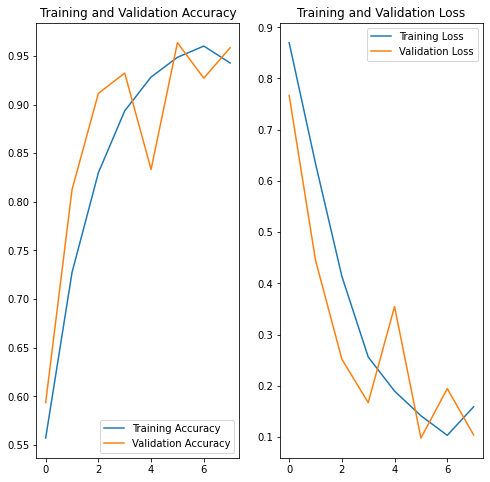

In [110]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [111]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 3s 48ms/step - loss: 0.1278 - accuracy: 0.9570
Test Accuracy: 95.7%


In [112]:
y_true = np.concatenate([y for x, y in test_ds], axis=0) 

In [113]:
y_pred = list()
for i in model.predict(test_ds):
  y_pred.append(np.argmax(i))
y_pred = np.array(y_pred)

In [117]:
from sklearn.metrics import  classification_report,confusion_matrix
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       134
           1       0.51      0.47      0.49       102
           2       0.32      0.35      0.33        20

    accuracy                           0.55       256
   macro avg       0.48      0.48      0.48       256
weighted avg       0.55      0.55      0.55       256



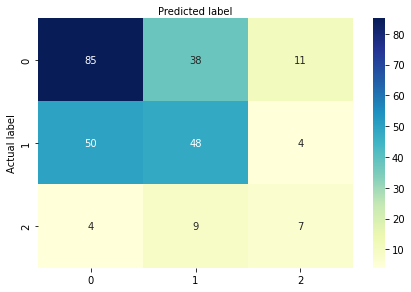

In [123]:
class_names = [0,1,2]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
cnf_matrix = confusion_matrix(y_true,y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu',
                fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()